In [1]:
import ctypes
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# MAIN

In [2]:
dirname = '../src/model_ctypes/_maleckar/'
filename_so = os.path.join(dirname, 'maleckar.so')

filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

model.run.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS')
]
model.run.restype = ctypes.c_int


legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value']
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']
legend_algebraic = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')

In [3]:
# model.initialize_states_default.argtypes = [
#     np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
# ]
# model.initialize_states_default.restype = ctypes.c_void_p


# model.initialize_constants_default.argtypes = [
#     np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
# ]
# model.initialize_constants_default.restype = ctypes.c_void_p

# values = np.zeros(len(legend_states))
# model.initialize_states_default(values)
# legend_states['value'] = values

# values = np.zeros(len(legend_constants))
# model.initialize_constants_default(values)
# legend_constants['value'] = values

In [4]:
# legend_constants[['name', 'value', 'units', 'component']].to_csv(os.path.join(dirname, "legend_constants.csv"), index=False)
# legend_states[['name', 'value', 'units', 'component']].to_csv(os.path.join(dirname, "legend_states.csv"), index=False)
# legend_algebraic[['name', 'value', 'units', 'component']].to_csv(os.path.join(dirname, "legend_algebraic.csv"), index=False)

In [5]:
S = legend_states.copy()
C = legend_constants.copy()
A = legend_algebraic.copy()

In [6]:
C['stim_duration'] = 0.001
C['stim_amplitude'] = -60

In [7]:
t_sampling = 0.001

#C['stim_period'] = 2000
stim_period = C['stim_period']
n_samples_per_stim = int(stim_period / t_sampling)

n_beats = 100
tol = 1e-6

output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
# output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
# t = np.zeros(n_samples_per_stim * n_beats + 1)

In [8]:
status = model.run(S.values.copy(), C.values.copy(),
                   n_beats, t_sampling, tol, output)

print(status)

2


In [9]:
output = pd.DataFrame(output, columns=legend_states.index)
# output_A = pd.DataFrame(output_A, columns=legend_algebraic.index)

In [10]:
err_abs = output.iloc[-1] - output.iloc[0]
err_rel = err_abs / output.iloc[0] * 100

items = ['Na_i', 'K_i', 'V', 'Ca_i']
# items = ['Nai', 'Ki']

df_err= pd.DataFrame([err_rel[items], err_abs[items]],
                     index=['err_rel', 'err_abs'])
df_err

name,Na_i,K_i,V,Ca_i
err_rel,-2.126157,0.148719,-0.268179,-4.814883
err_abs,-0.181080,0.192571,0.198538,-0.000003


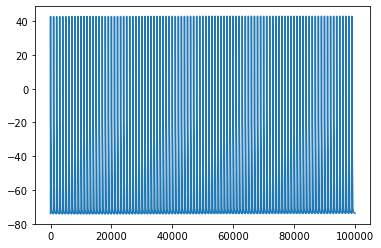

In [11]:
plt.plot(output.V)

In [12]:
atol = (output.abs().min() / 10).clip(lower=1e-6, upper=1e-3)
atol = np.power(10, np.log10(atol).round())

s = ""
for i, name in enumerate(atol.index):
    x = f'/*{name}*/ {atol[name]}, '
    s += x
    s += (20 - len(x)) * ' '
    if i % 5 == 4:
        s += '\n'

In [13]:
print(s)

/*V*/ 0.001,        /*Na_c*/ 0.001,     /*Na_i*/ 0.001,     /*m*/ 0.001,        /*h1*/ 1e-06,       
/*h2*/ 1e-05,       /*Ca_d*/ 1e-05,     /*d_L*/ 1e-06,      /*f_L1*/ 0.001,     /*f_L2*/ 0.001,     
/*K_c*/ 0.001,      /*K_i*/ 0.001,      /*r*/ 0.0001,       /*s*/ 0.001,        /*a_ur*/ 0.0001,    
/*i_ur*/ 0.001,     /*n*/ 0.001,        /*pa*/ 1e-05,       /*Ca_c*/ 0.001,     /*Ca_i*/ 1e-05,     
/*O_C*/ 0.001,      /*O_TC*/ 0.001,     /*O_TMgC*/ 0.001,   /*O_TMgMg*/ 0.001,  /*O*/ 0.001,        
/*Ca_rel*/ 0.001,   /*Ca_up*/ 0.001,    /*O_Calse*/ 0.001,  /*F1*/ 0.001,       /*F2*/ 0.0001,      



# Syn

In [20]:
from tqdm.auto import tqdm

In [22]:
for CL in tqdm([2000, 1000, 666, 500, 333, 250]):
    
    stim_period = CL / 1000.
    C['stim_period'] = stim_period
    n_samples_per_stim = int(stim_period / t_sampling)

    n_beats = 1000
    tol = 1e-6

    output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
    # output_A = np.zeros((n_samples_per_stim * n_beats + 1, len(A)))
    # t = np.zeros(n_samples_per_stim * n_beats + 1)
    
    status = model.run(S.values.copy(), C.values.copy(),
                   n_beats, t_sampling, tol, output)

    print(status)
    
    output = pd.DataFrame(output, columns=legend_states.index)

    phenotype = output[-CL - 1:][:1000]
    state = phenotype.iloc[0]
    
    
    err_abs = output.iloc[-1] - output.iloc[0]
    err_rel = err_abs / output.iloc[0] * 100

    items = ['Na_i', 'K_i', 'V', 'Ca_i']
    # items = ['Nai', 'Ki']

    df_err= pd.DataFrame([err_rel[items], err_abs[items]],
                         index=['err_rel', 'err_abs'])
    print(df_err)

    
    dirname = "../data/maleckar/original/"
    
    phenotype_filename = os.path.join(dirname, f'phenotypes/phenotype_{CL}.csv')
    state_filename = os.path.join(dirname, f'states/state_{CL}.txt')
    
    phenotype.to_csv(phenotype_filename, index=False)
    np.savetxt(state_filename, state)

  0%|          | 0/6 [00:00<?, ?it/s]

2
name          Na_i       K_i         V       Ca_i
err_rel -12.448987  0.862311 -0.913353 -22.274577
err_abs  -1.060251  1.116572  0.676173  -0.000014
2
name         Na_i       K_i         V      Ca_i
err_rel -4.150653  0.284796 -0.927499 -6.589041
err_abs -0.353501  0.368770  0.686646 -0.000004
2
name         Na_i       K_i         V       Ca_i
err_rel  3.458790 -0.248432 -1.532629  14.883991
err_abs  0.294577 -0.321684  1.134636   0.000010
2
name          Na_i       K_i         V       Ca_i
err_rel  10.128843 -0.721510 -2.804624  45.061866
err_abs   0.862650 -0.934254  2.076318   0.000029
2
name          Na_i       K_i         V        Ca_i
err_rel  18.592902 -1.341083 -7.241924  132.182790
err_abs   1.583514 -1.736514  5.361340    0.000086
2
name          Na_i       K_i          V        Ca_i
err_rel  19.820611 -1.470969 -11.755463  201.585965
err_abs   1.688075 -1.904699   8.702802    0.000131


  0%|          | 0/6 [00:00<?, ?it/s]

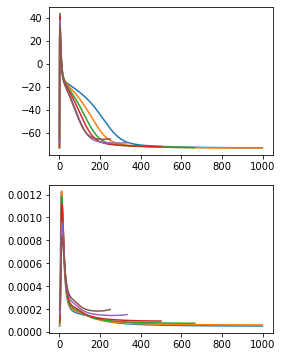

In [23]:
fig, axes = plt.subplots(nrows=2, figsize=plt.figaspect(1.5))

for CL in tqdm([2000, 1000, 666, 500, 333, 250]):
    
    phenotype_filename = os.path.join(dirname, f'phenotypes/phenotype_{CL}.csv')
    df = pd.read_csv(phenotype_filename)
    
    axes[0].plot(df.V)
    axes[1].plot(df.Ca_i)